# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


In [5]:
! nvidia-smi

Thu Jul  3 14:55:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 30%   54C    P3              84W / 350W |   1005MiB / 24576MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [6]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


I0000 00:00:1751547331.409799   47478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751547331.431856   47478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751547331.431965   47478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751547331.439531   47478 service.cc:146] XLA service 0x33452150 initialized for platfor

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [7]:
nom_projet                = '01-La preparation des données-MNIST'
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')


    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def lectureModel(self, model_filename):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    fullpath = self.saved_models_dir+'/'+model_filename+'.keras'
    if os.path.exists(fullpath):
        if os.path.isfile(fullpath):
            model = load_model(fullpath)
            return model
    return None    

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history

def afficheHistoriqueEntrainement(history, palette):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    sauvegarderImage('afficheHistoriqueEntrainement')
    

In [8]:
# reshape a Python array using reshape() called from NumPy
demoData = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
newData = np.reshape(demoData, (6, 2))
print(newData)

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]


In [9]:
# reshape a NumPy array by calling reshape() as one of its methods
demoData = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
newData = demoData.reshape((6, 2))
print(newData)

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]


In [10]:
# reshaping to an incompatible size causes an error
demoData = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
# uncomment the next line to see the error
# demoData.reshape((5,15))

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [16]:
random_seed = 42
np.random.seed(random_seed)

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
# X_train = tf.cast(X_train, tf.float32)
# X_test  = tf.cast(X_test, tf.float32)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=number_of_classes)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage d'un échantillon de données</div></b>

In [31]:
def show_demo_grid(seed, filename):
    # Show a grid of random digits
    demo_grid = [[[] for x in range(10)] for y in range(10)] 
    num_found = 0
    attempts = 0
    np.random.seed(seed)
    while (num_found < 100) and (attempts < X_train.shape[0]):
        attempts += 1
        index = np.random.randint(0, X_train.shape[0])
        label = original_y_train[index]
        placed = False
        for column in range(10):
            if (not placed) and (not demo_grid[label][column]):
                num_found += 1
                demo_grid[label][column] = index
                placed = True

    plt.figure(figsize=(24,28))
    for y in range(10):
        for x in range(10):
            plt.subplot(10, 10, 1 + (y*10) + x)
            list_index = demo_grid[y][x]
            img = X_train[list_index].reshape(28, 28)
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(np.argmax(y_train[list_index]))
            frame = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
    sauvegarderImage('Keras-PreparingData.'+filename)
    plt.show()

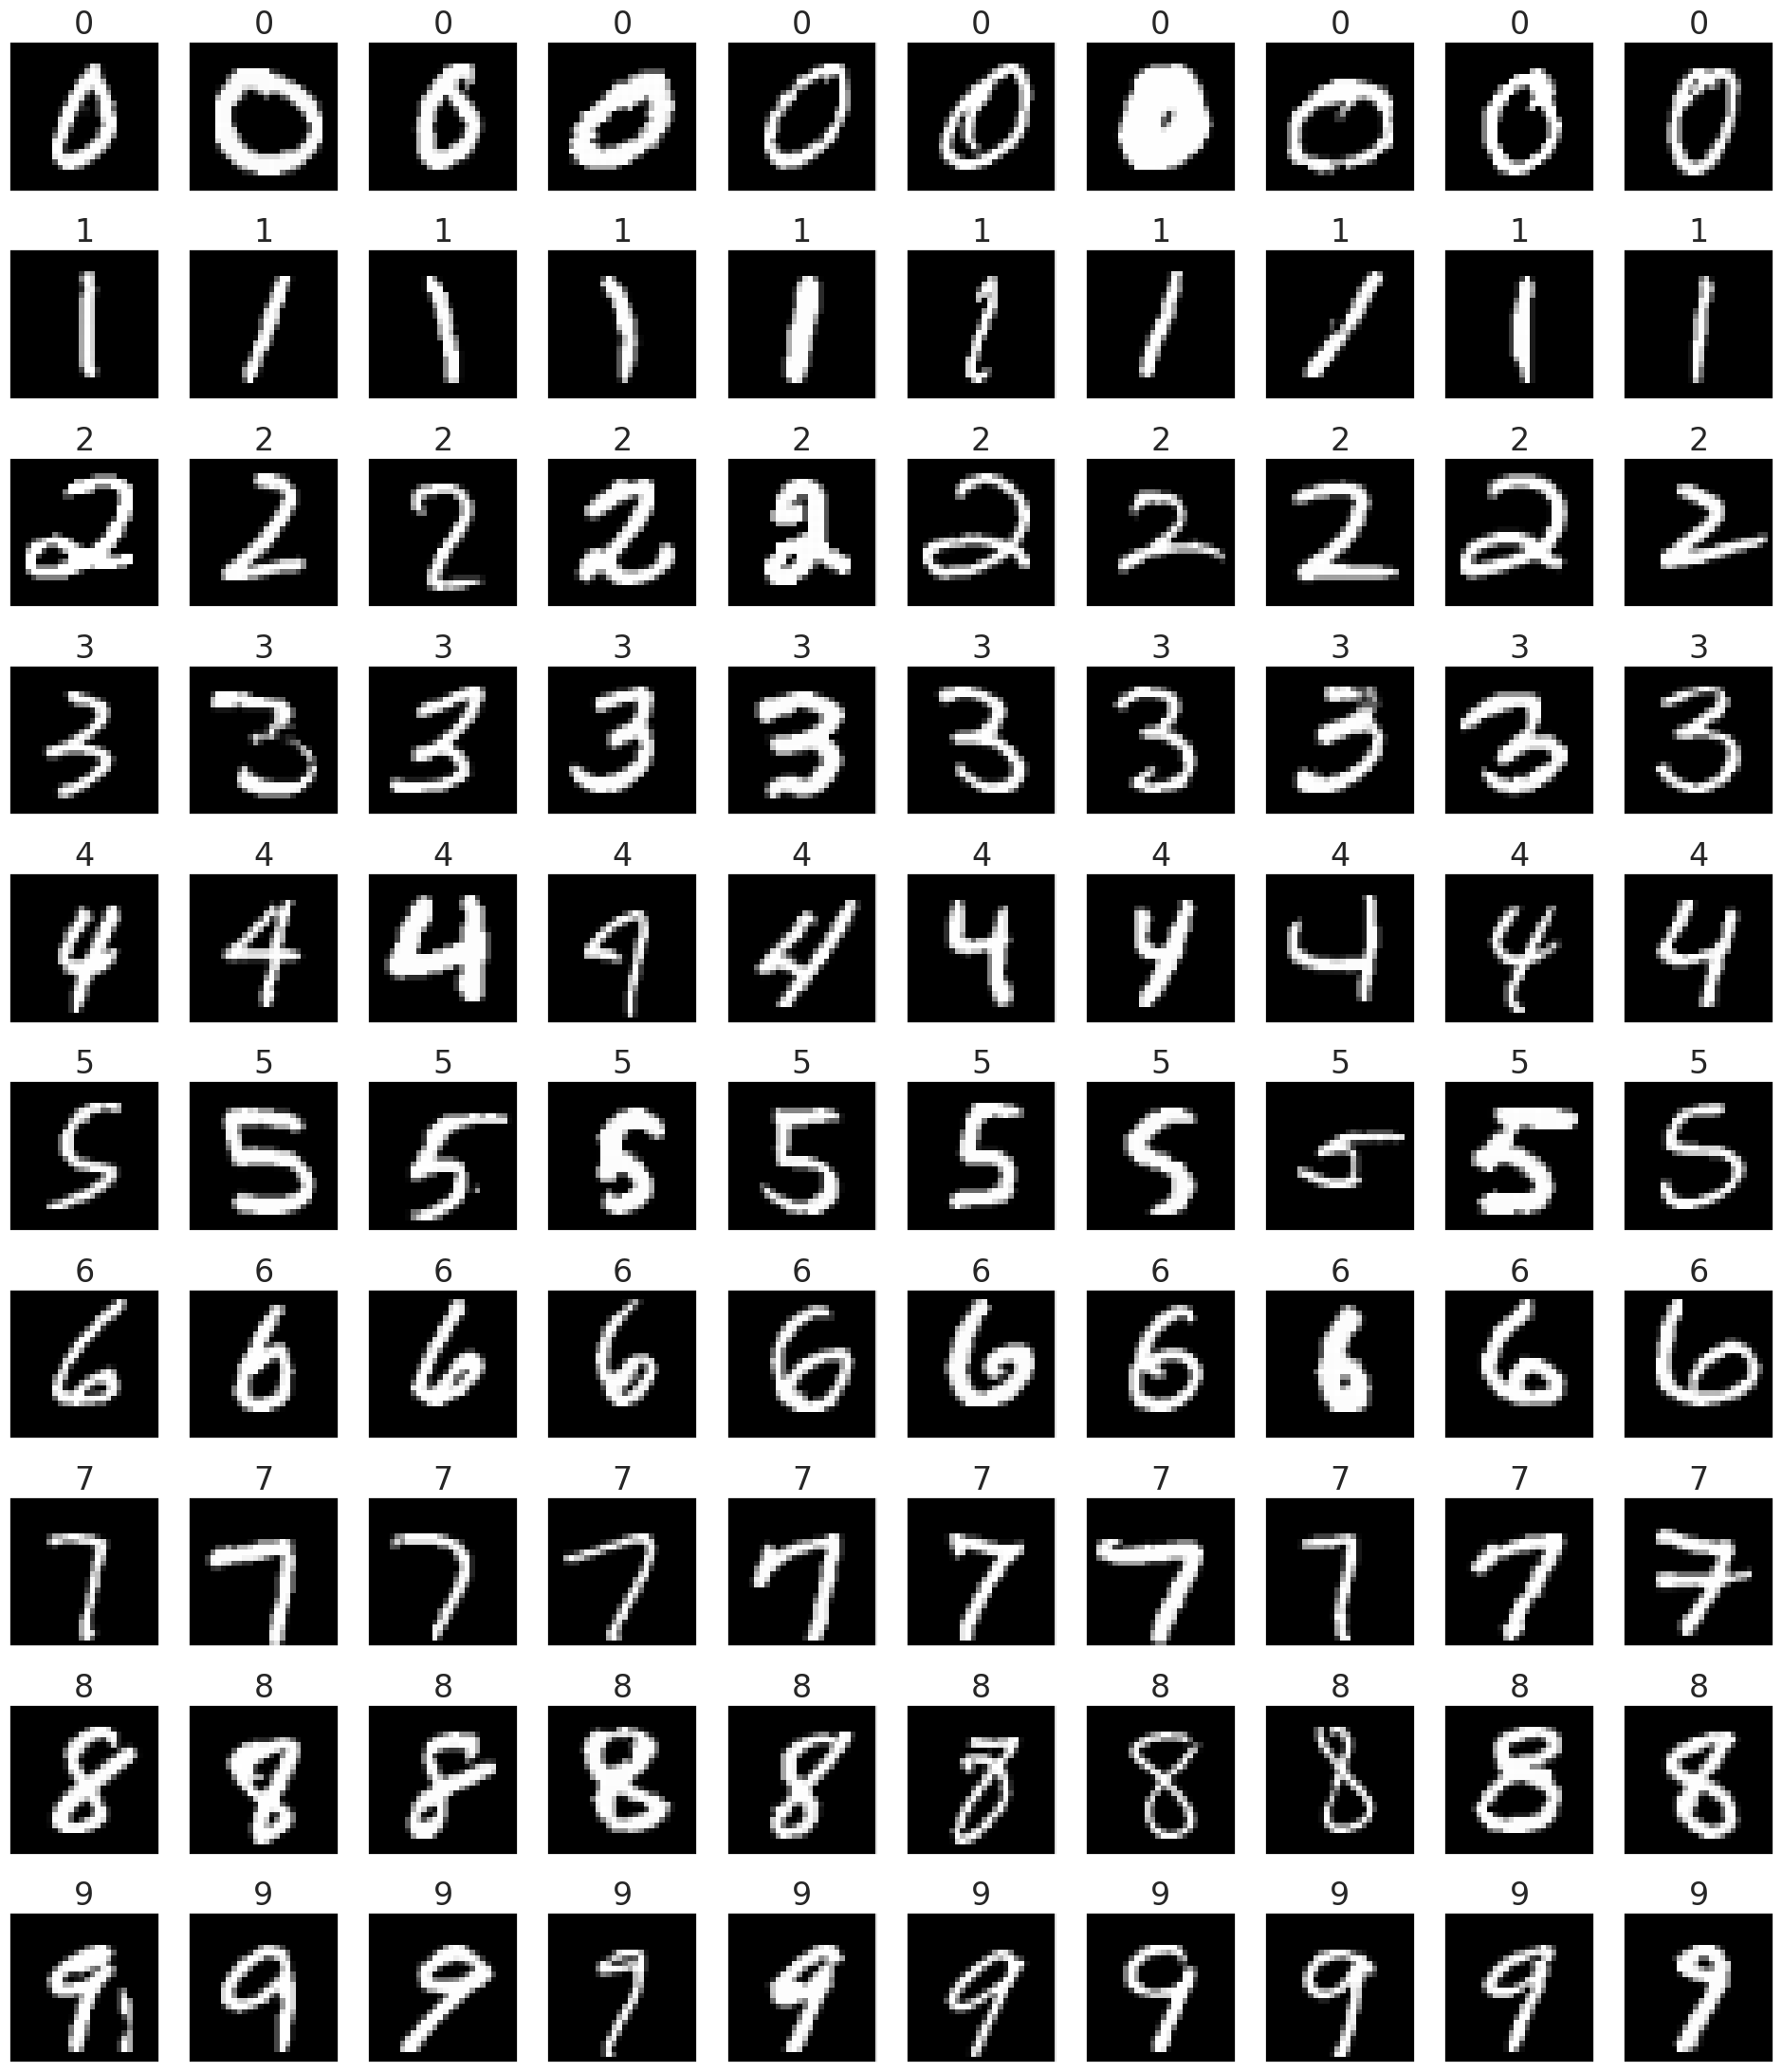

In [32]:
show_demo_grid(5, 'MNIST-demo')

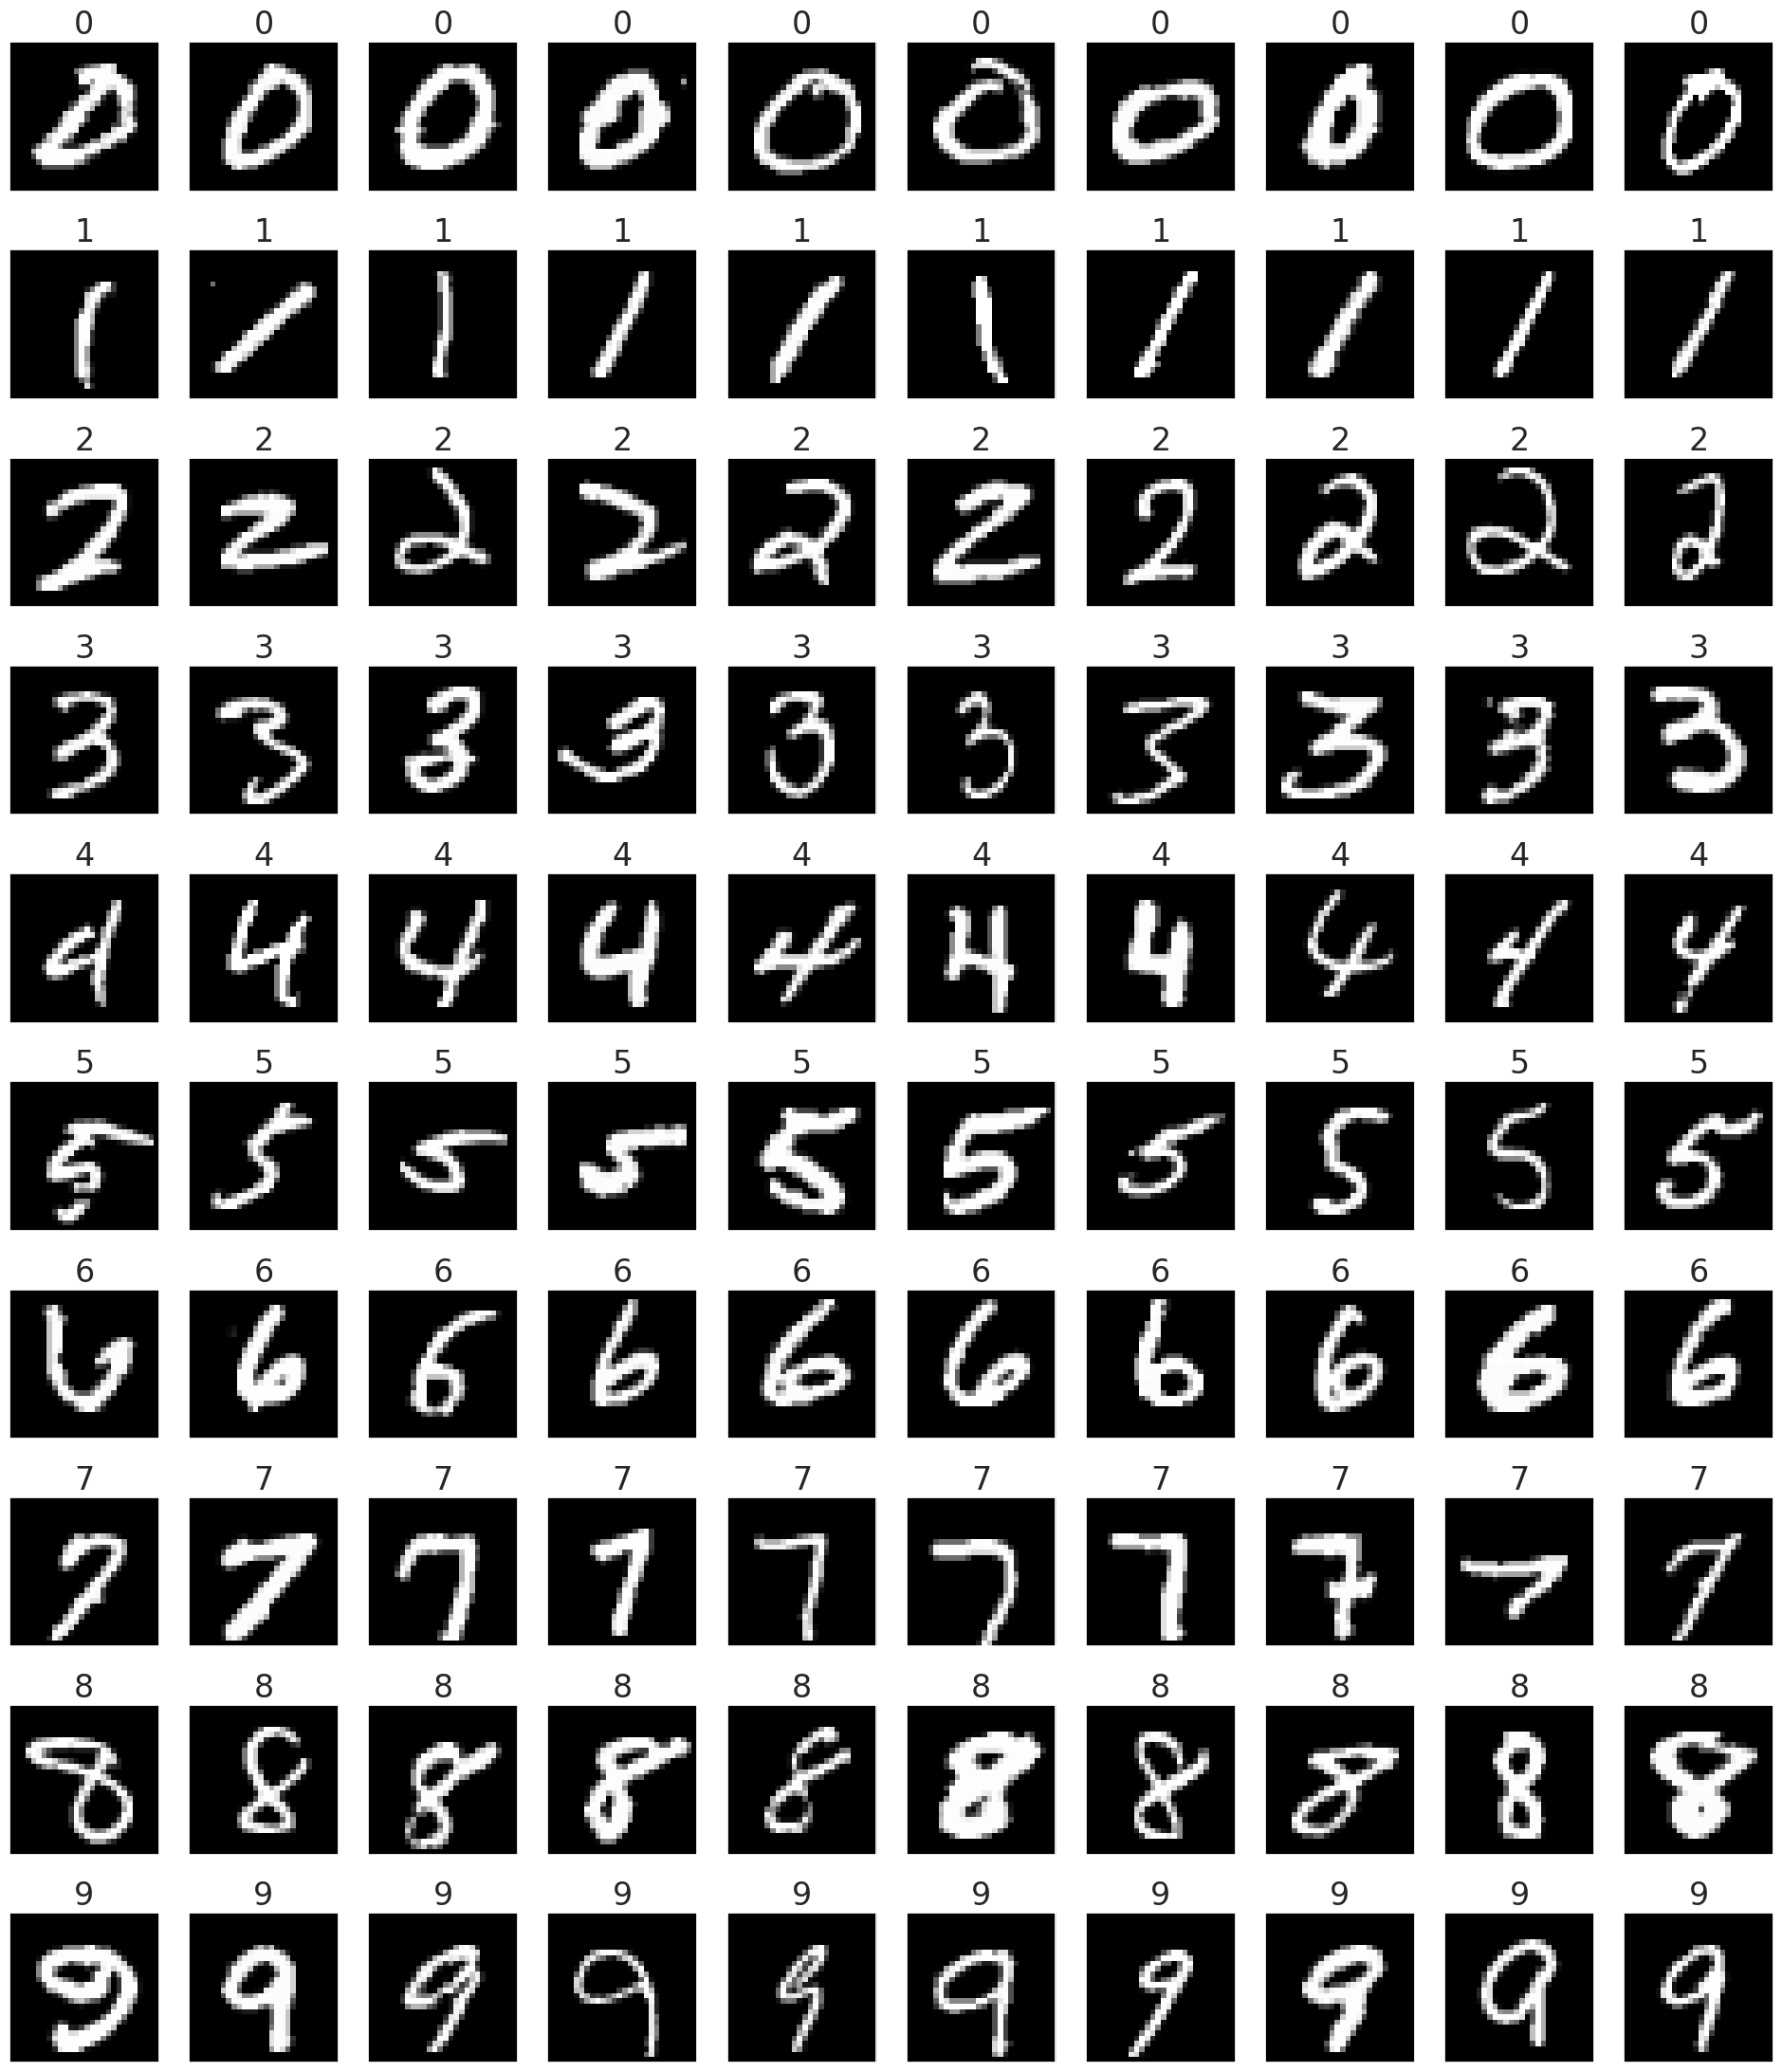

In [34]:
show_demo_grid(42, 'MNIST-demo2')

In [35]:
# show a set of training digits in 10-column form
def showset(setlist, filename = None):
    num_columns = 10 
    num_rows = int(len(setlist)/num_columns)
    plt.figure(figsize=(num_columns*3, num_rows*3))
    plt.subplots_adjust(hspace=0.4)
    for index in range(len(setlist)):
        y = int(index/num_columns)
        x = index - (y*num_columns)
        plt.subplot(num_rows, num_columns, 1 + index)
        img = X_train[setlist[index]].reshape(28, 28)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.title(str(setlist[index]), fontsize=24)
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    sauvegarderImage('Keras-PreparingData.'+filename)
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()
    

# I built up these lists by hand while looking through the training set
confusing = ( 8689, 51176, 50994, 3370, 
            4986, 4522, 57380, 9472, 140, 494, 
            56569, 54975,
            54834, 56286,
            11711, 14335, 15324, 15434, 15862, 
            40664, 50239, 50856, 
            16676, 26398, 26624, 27514, 29897, 
            40876, 52074, 53638)

cropped = ( 12184, 3089, 3002, 9363, 2231, 26447,
           28491, 500, 5052, 55475, 
           #6498, 6506,
          #7142, 7434, 517, 875, 957, 1101, 2135,
          #10124, 16192, 16938, 20446, 25692, 873, 
          #50391, 52514, 4761, 53006, 53248, 56678 
          )

noisy = ( 51323, 51363, 51459, 53205, 55539, 
         26471, 25159,7599, 10677, 58871,
         #2595, 3163, 3867, 5009, 9139, 1875, 7329,
        #7947, 8675, 9395, 451, 67, 933, 1023, 1165, 1157,
        #1623, 1677, 10251, 10867, 11853, 12113, 12123,
        #26391, 40977, 2693, 29437, 
        #58797, 13259, 14929, 15309, 16275,  25801, 27793,
        #40159, 50459, 51863, 52253, 54085, 55285, 56659, 
        #58801, 15963,  3065, 
        )

edged = ( 2492, 4880, 3442, 11947, 7195, 4759, 3382, 2133, 
         7192, 2380, 
         #3349, 3599, 3991, 
        #4396, 3894, 5892, 5893, 5897, 7198, 
        #8990, 8991, 11894, 11898, 3835, 12599 
        )

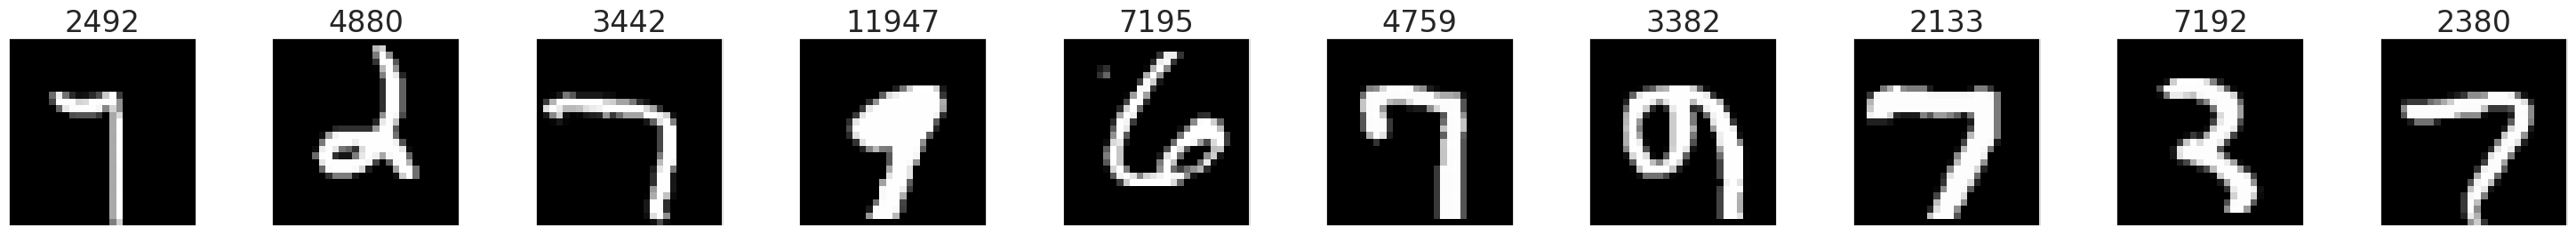

In [36]:
showset(edged, 'MNIST-edged')

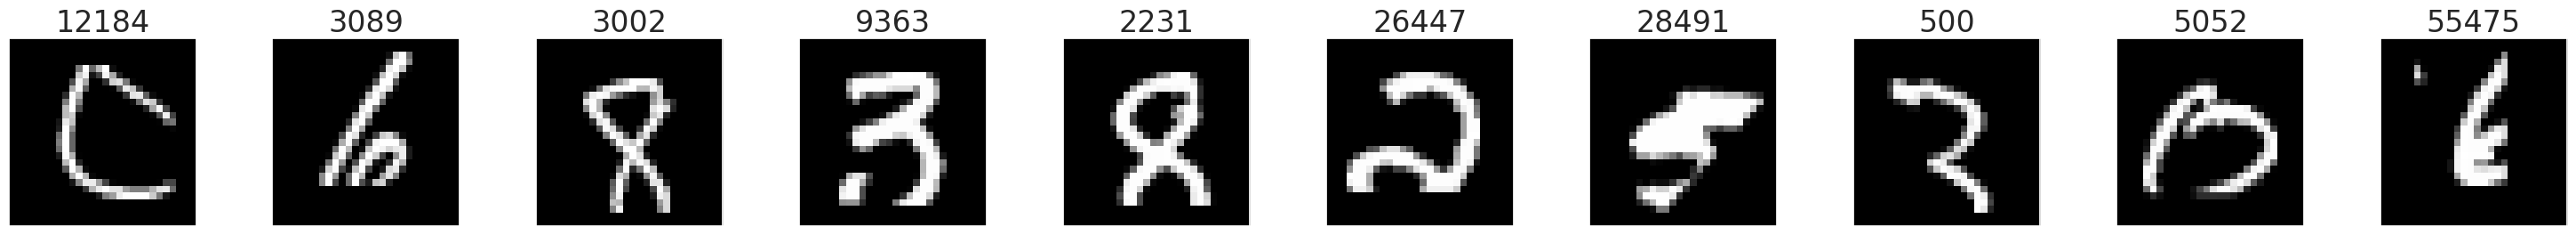

In [37]:
showset(cropped, 'MNIST-miscropped')

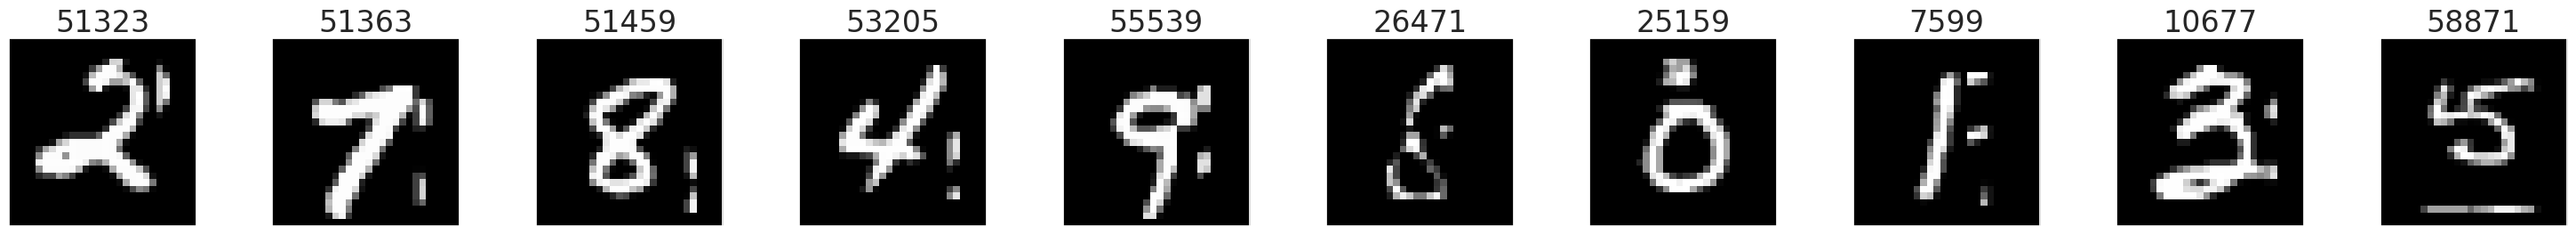

In [38]:
showset(noisy, 'MNIST-noisy')

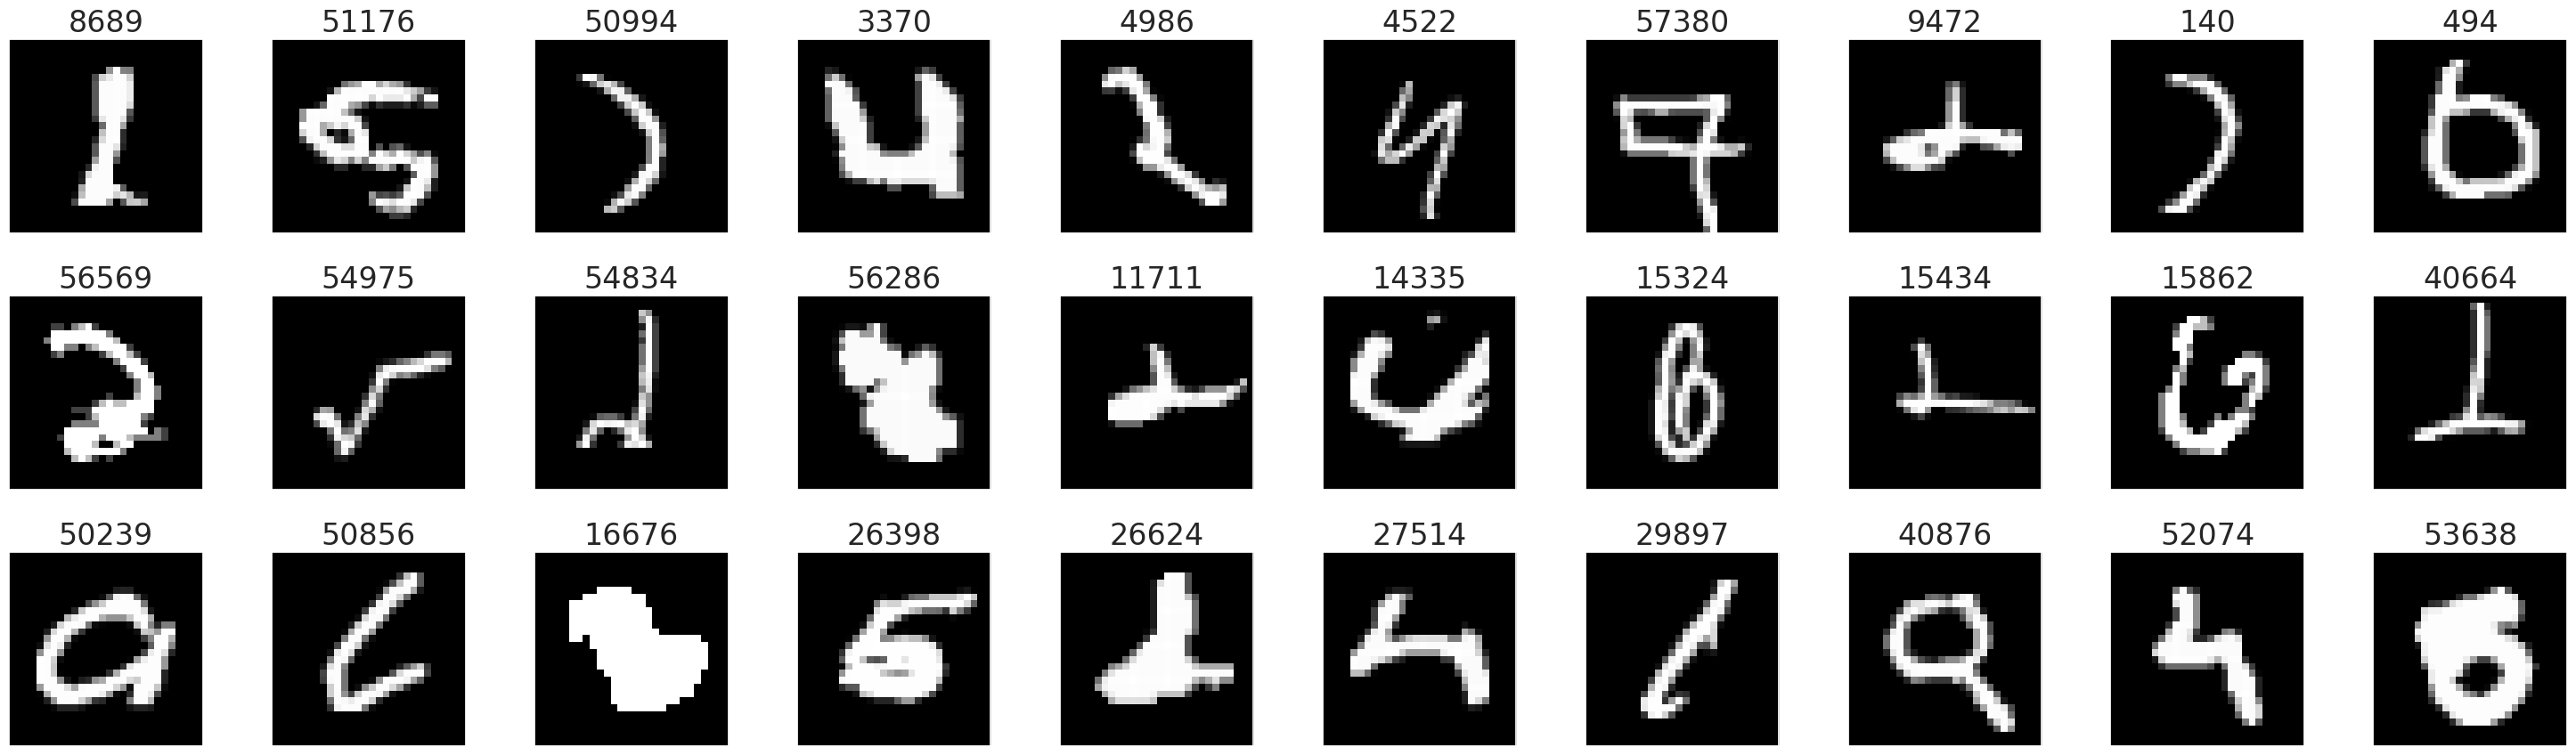

In [39]:
showset(confusing, 'MNIST-confusing')

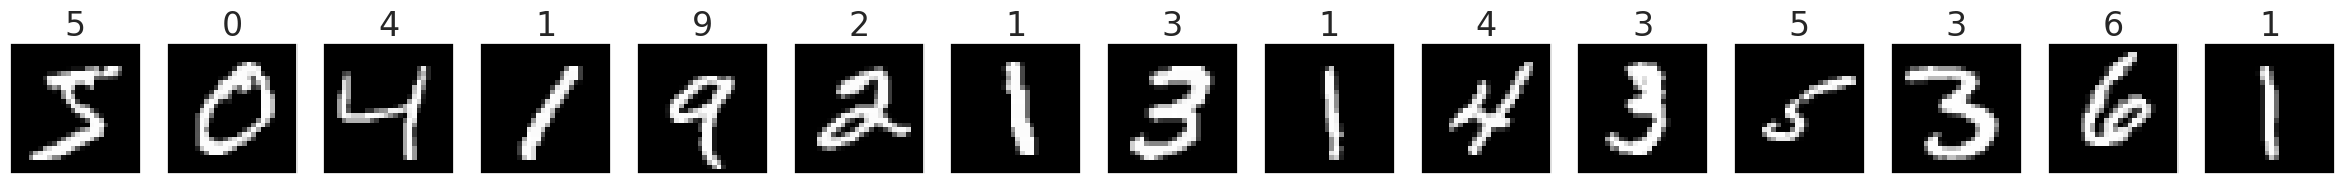

In [40]:
# Show the first few images
num_images = 15    
plt.figure(figsize=(30, 5))
for i in range(num_images):

    plt.subplot(1, num_images, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(original_y_train[i], fontsize=24)
    plt.xticks([],[])
    plt.yticks([],[])
sauvegarderImage('Keras-PreparingData.MNIST-first-few')
plt.show()

In [41]:
one_hot = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
print("one_hot represents the integer ",one_hot.index(1))

one_hot represents the integer  3


In [42]:
one_hot_np = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
print("one_hot_np represents the integer ",np.argmax(one_hot_np))

one_hot_np represents the integer  3
